In [1]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.distributions import Normal

import math
import time

from Data import *
from nets.LTU import LTU, encoder, decoder
from nets.MLP import MLP
from flows.build import build_flow

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def base_dist():
    return Normal(
        loc=torch.zeros(2, device=device),
        scale=torch.ones(2, device=device),
    )

In [4]:
batch_size = 2
Data = Data('two_blobs.csv')

train_dataloader, test_dataloader = Data.return_dataloaders(batch_size = batch_size)

num_batches = train_dataloader.__len__()
 

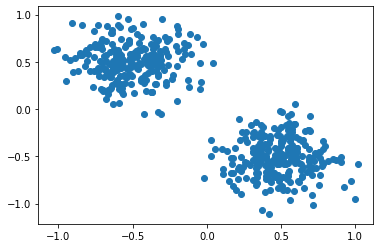

In [5]:
Data.plot_scatter()

## Planar

In [6]:
enc = encoder(hidden_sizes=[128, 64, 32, 2*2]).to(device)
net = LTU()
dec = decoder(hidden_sizes=[32, 64, 128, 2]).to(device)
# net

In [7]:
a = torch.Tensor([[0.7,0.88],[0.4,0.5]]).to(device)
enc(a), dec(a)


(tensor([[ 0.1634, -0.1150, -0.1306, -0.0755],
         [ 0.1227, -0.0999, -0.0978, -0.0736]], device='cuda:0',
        grad_fn=<TanhBackward0>),
 tensor([[0.0246, 0.0510],
         [0.0240, 0.0467]], device='cuda:0', grad_fn=<GeluBackward0>))

In [8]:
flow_planar= build_flow(name = 'planar', net = net, dim= 12, device = device).flow.to(device)
# print(flow_planar)

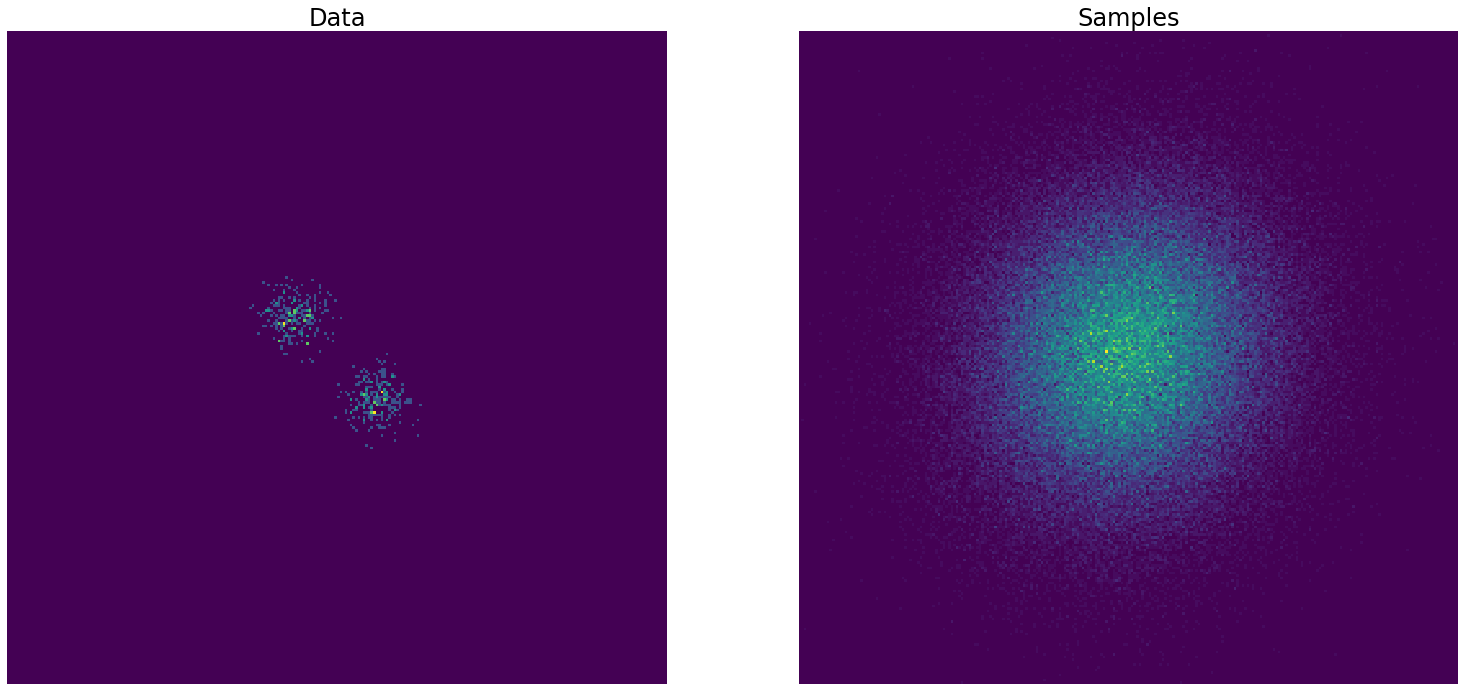

In [9]:
fig = Data.plot_samples(flow_planar.sample(128000))
fig.savefig('results/Planar_two_blobs_before.pdf')

In [10]:
flow_planar

Flow(
  (flow): ModuleList(
    (0): Planar(
      (net): LTU(
        (layer1): Matmul()
        (layer2): Matadd()
        (layer3): Tanh()
        (layer4): Matmul()
      )
    )
    (1): Planar(
      (net): LTU(
        (layer1): Matmul()
        (layer2): Matadd()
        (layer3): Tanh()
        (layer4): Matmul()
      )
    )
    (2): Planar(
      (net): LTU(
        (layer1): Matmul()
        (layer2): Matadd()
        (layer3): Tanh()
        (layer4): Matmul()
      )
    )
    (3): Planar(
      (net): LTU(
        (layer1): Matmul()
        (layer2): Matadd()
        (layer3): Tanh()
        (layer4): Matmul()
      )
    )
    (4): Planar(
      (net): LTU(
        (layer1): Matmul()
        (layer2): Matadd()
        (layer3): Tanh()
        (layer4): Matmul()
      )
    )
    (5): Planar(
      (net): LTU(
        (layer1): Matmul()
        (layer2): Matadd()
        (layer3): Tanh()
        (layer4): Matmul()
      )
    )
    (6): Planar(
      (net): LTU(
       

In [11]:
a = torch.Tensor([[0.7,0.88],[0.4,0.5]]).to(device)
flow_planar.flow_outputs(a)

(tensor([[0.6708, 1.1000],
         [0.3779, 0.6661]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([0.0503, 0.0525], device='cuda:0', grad_fn=<AddBackward0>))

In [12]:
loss_fn = BCEWithLogitsLoss()

#Train

optimizer = torch.optim.Adam(list(enc.parameters()) + list(flow_planar.parameters()) + list(dec.parameters()))
epochs = 300

start  = time.time()

print('Training...')

flow_planar = flow_planar.train()

for epoch in range(epochs):
    loss_sum = 0.0
    
    for i, x in enumerate(train_dataloader):
#         print(i)
        batch_size = len(x)
        x = x.to(device)
        optimizer.zero_grad()
        x_ = enc(x)
        mu, log_sigma = x_[:,0:2], x_[:,2:4]
        sigma = torch.exp(log_sigma)
        
        # Sample from z ~ N(0,I).        
#         z = torch.zeros(size= [batch_size,1]).normal_(mean=0, std=1)
        z = torch.zeros(size=(batch_size, 2)).normal_(mean=0, std=1)
        z = z.to(device)
        z0 = z*sigma + mu  
        
        log_prob_z0 = torch.sum(-0.5 * torch.log(torch.tensor(2 * math.pi)) - 
                                log_sigma - 0.5 * ((z0 - mu) / sigma) ** 2, axis=1)
        
        zk, log_det = flow_planar.flow_outputs(z0)
        log_prob_zk = torch.sum(-0.5 * (torch.log(torch.tensor(2 * math.pi))+ zk ** 2), axis=1)
        x_hat = dec(zk)
        
        loss = torch.mean(log_prob_z0) + loss_fn(x_hat, x) - torch.mean(log_prob_zk) - torch.mean(log_det)
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
#         print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_dataloader)))
    if epoch %100 == 0 :    
        print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_dataloader)))
flow_planar = flow_planar.eval()

end = time.time()
print('Training takes ', (end-start)/3600, ' hrs')

Training...
Epoch: 1/300, Loss: 0.682
Epoch: 101/300, Loss: 0.613
Epoch: 201/300, Loss: 0.612
Training takes  0.36988782121075525  hrs


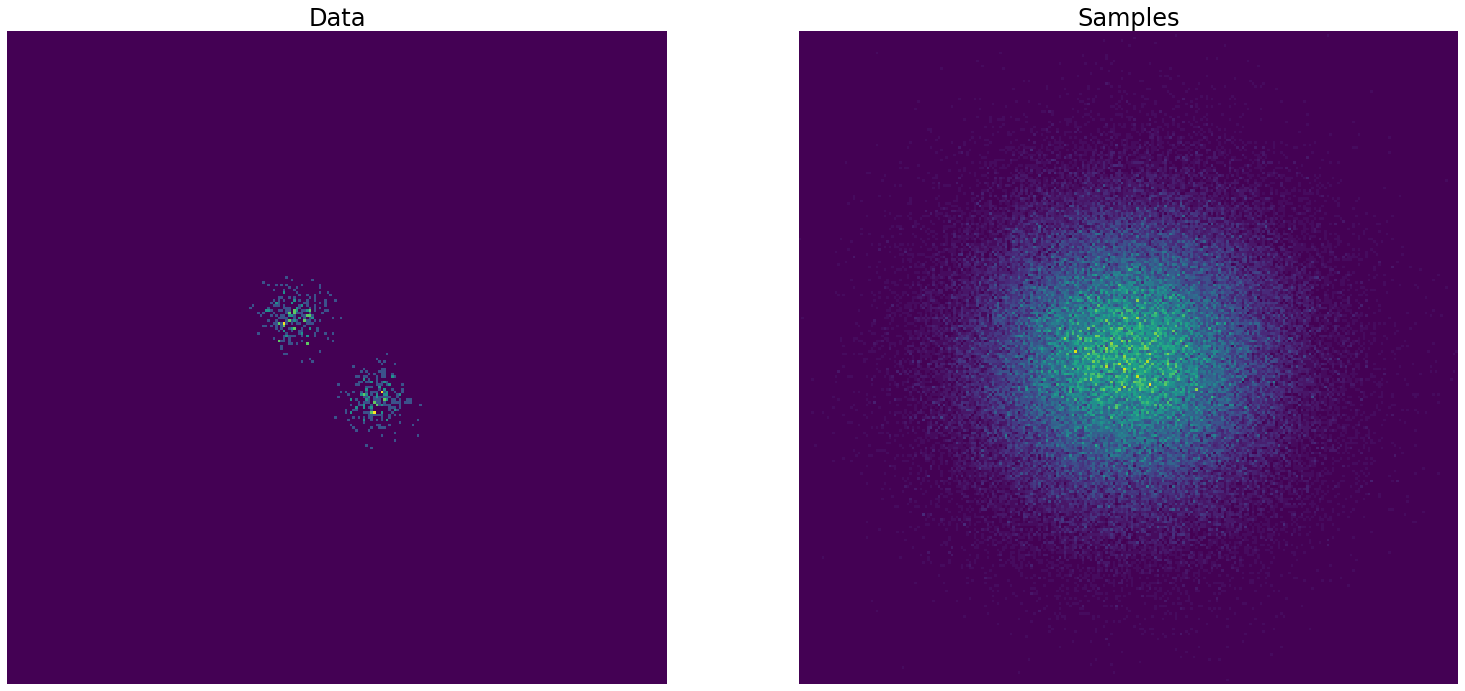

In [13]:
fig = Data.plot_samples(flow_planar.sample(128000))
fig.savefig('results/Planar_two_blobs_after.pdf')